# Data Exercise Photometry 

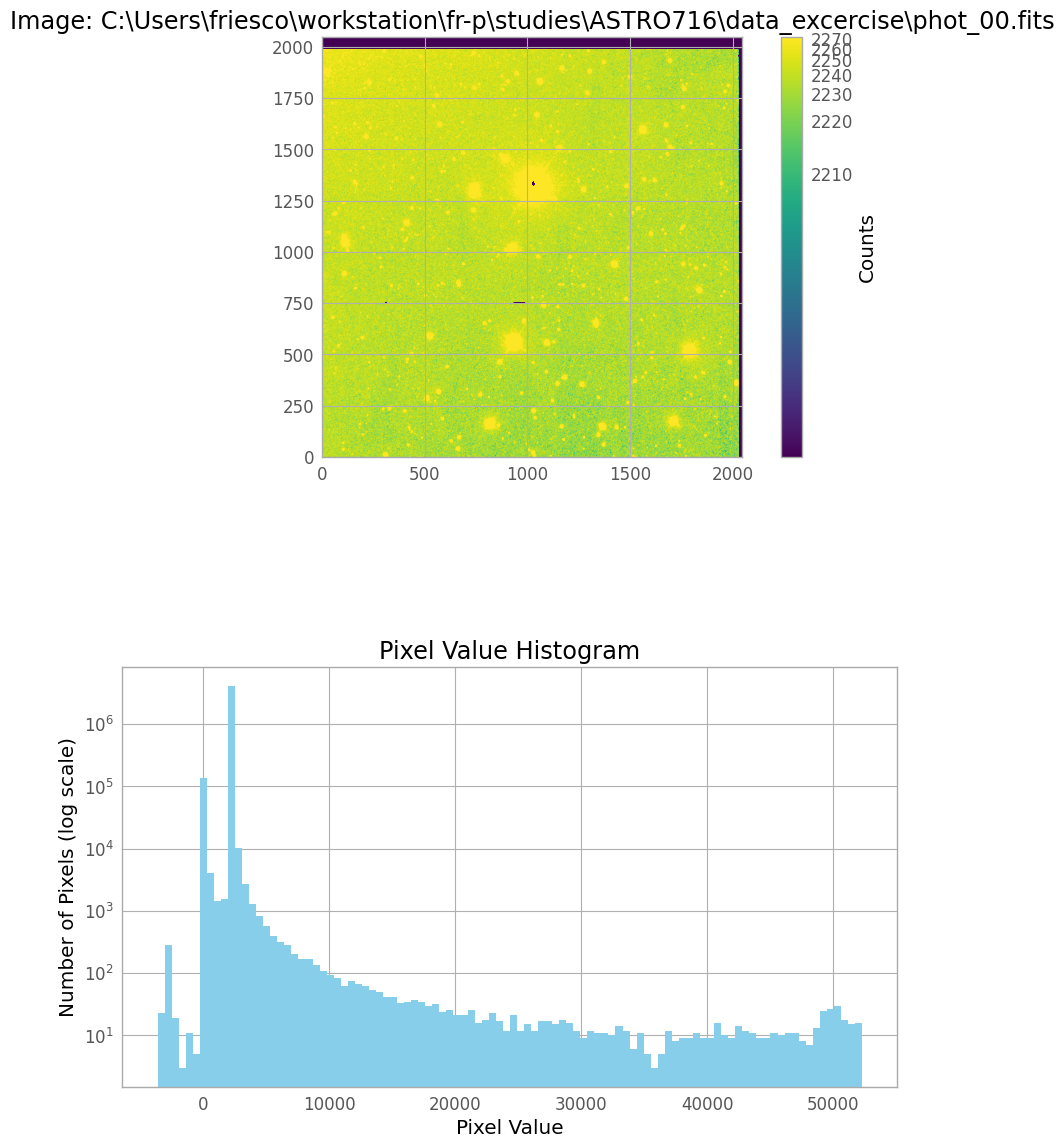

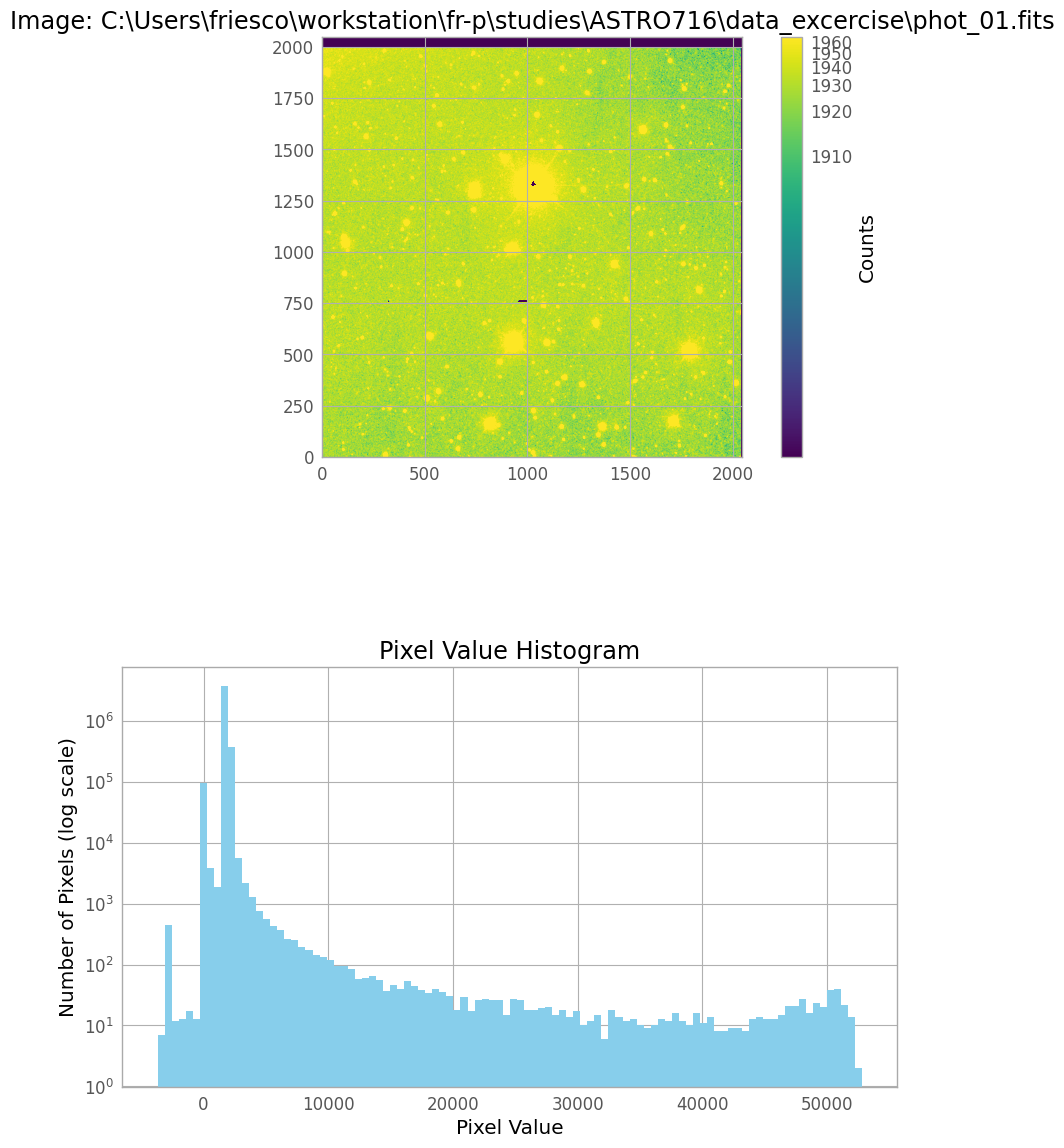

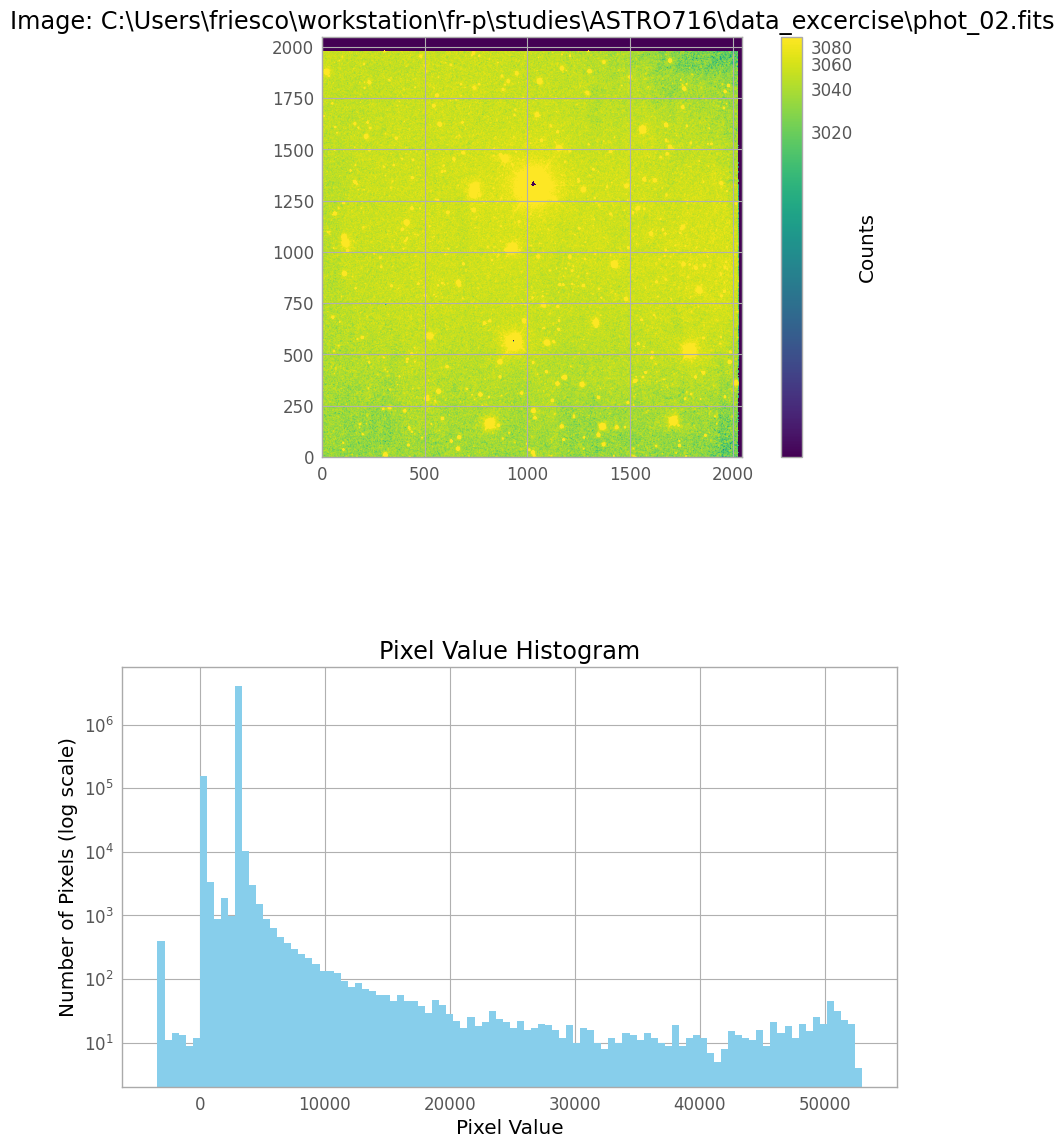

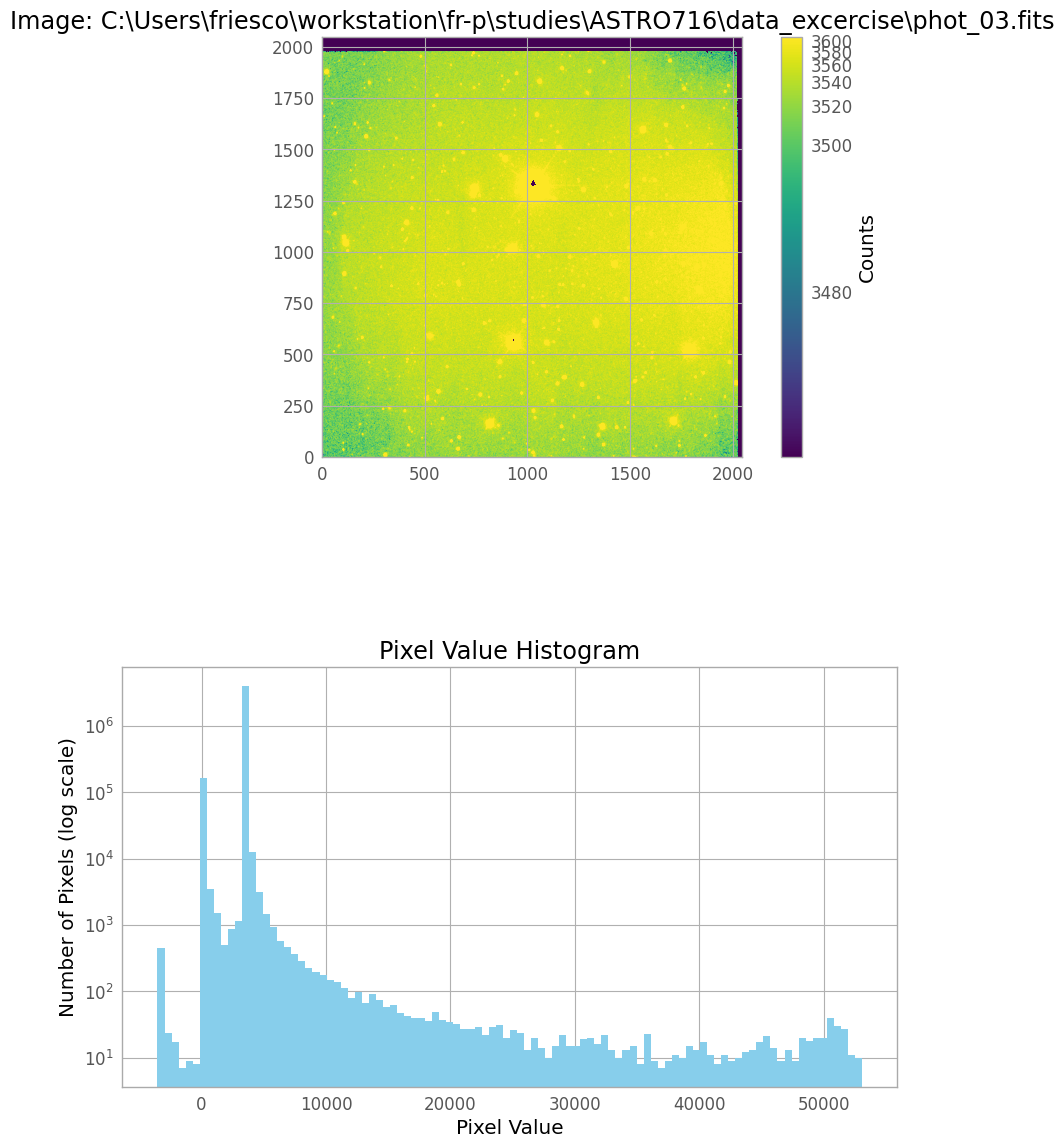

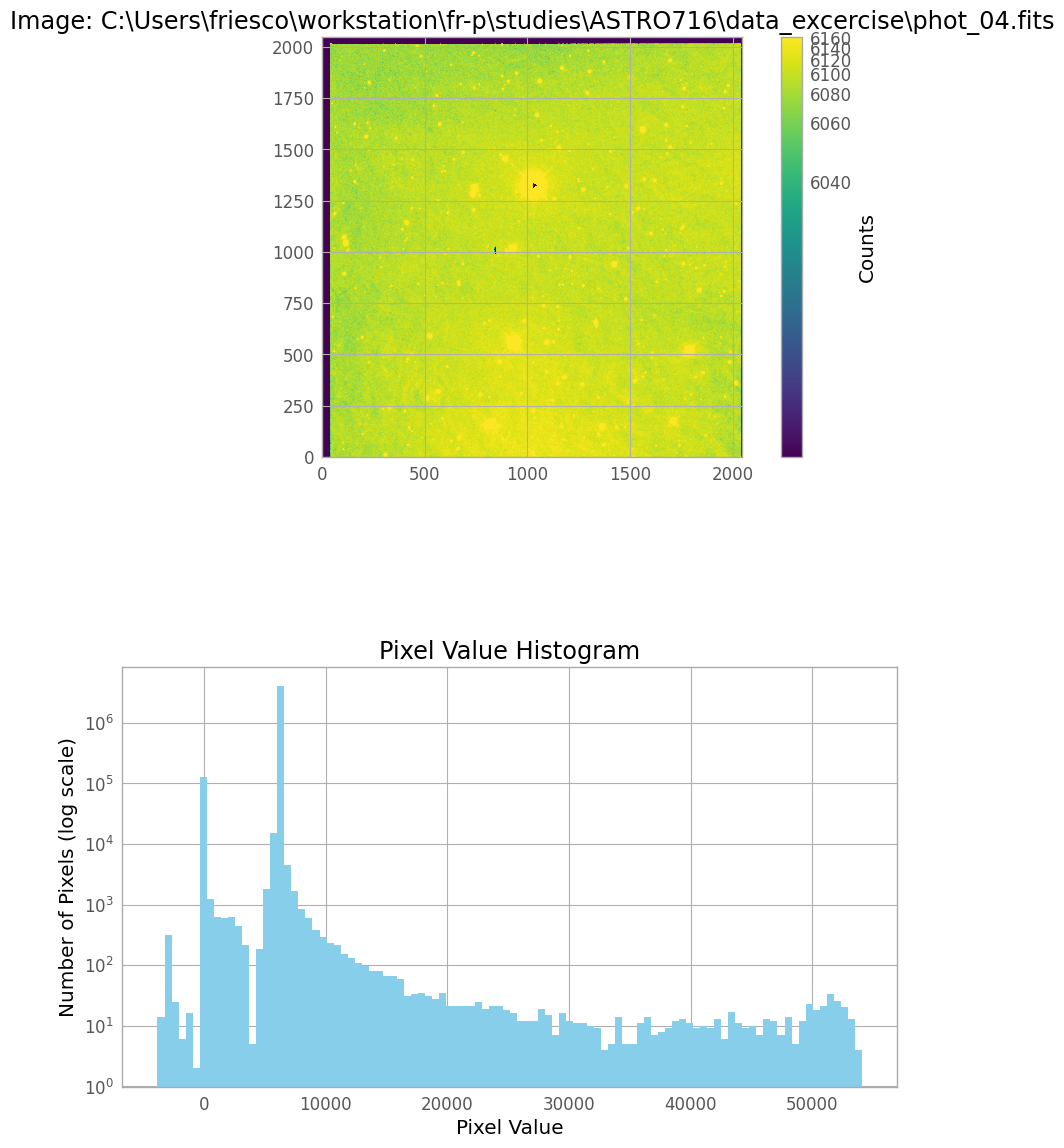

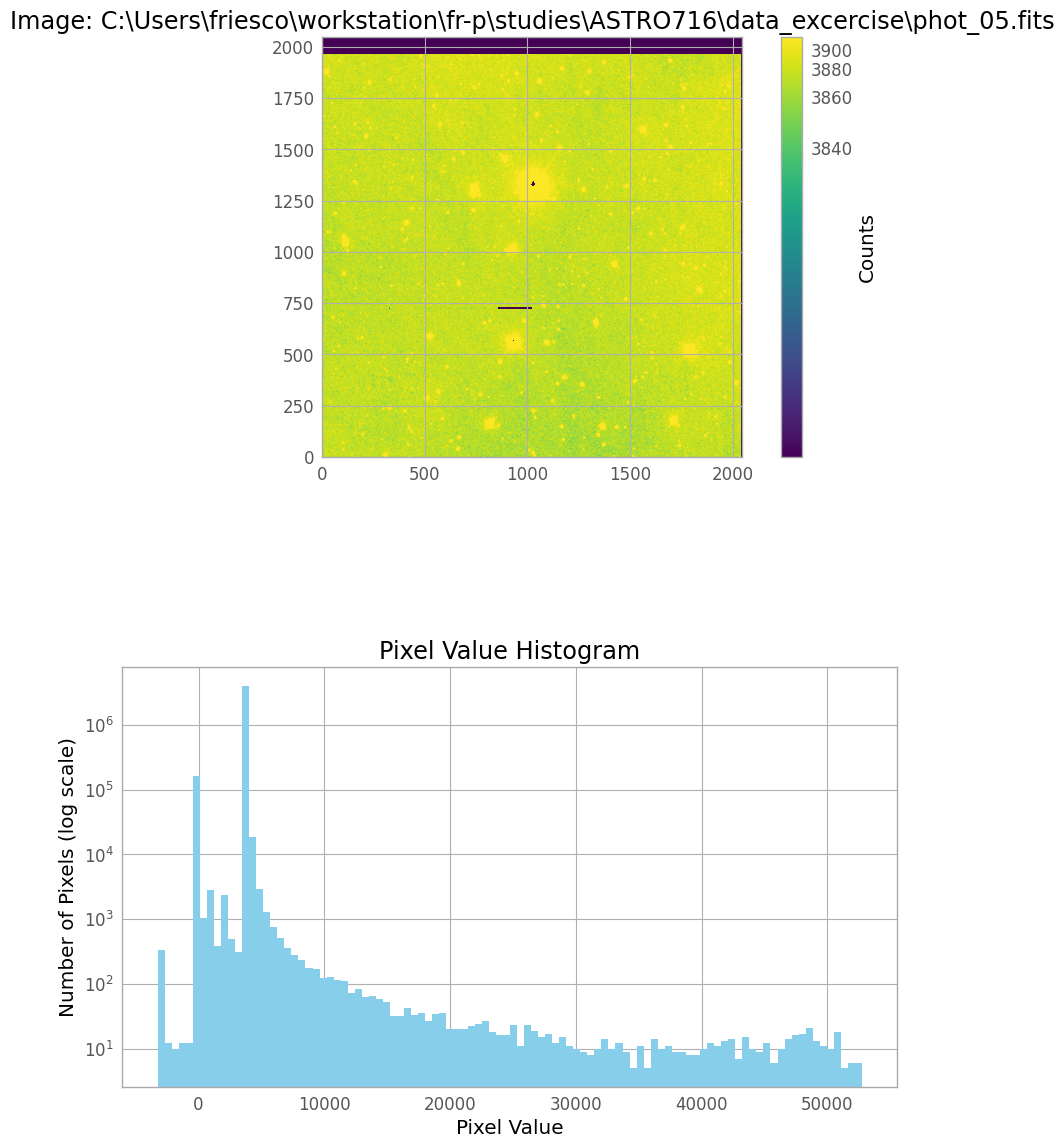

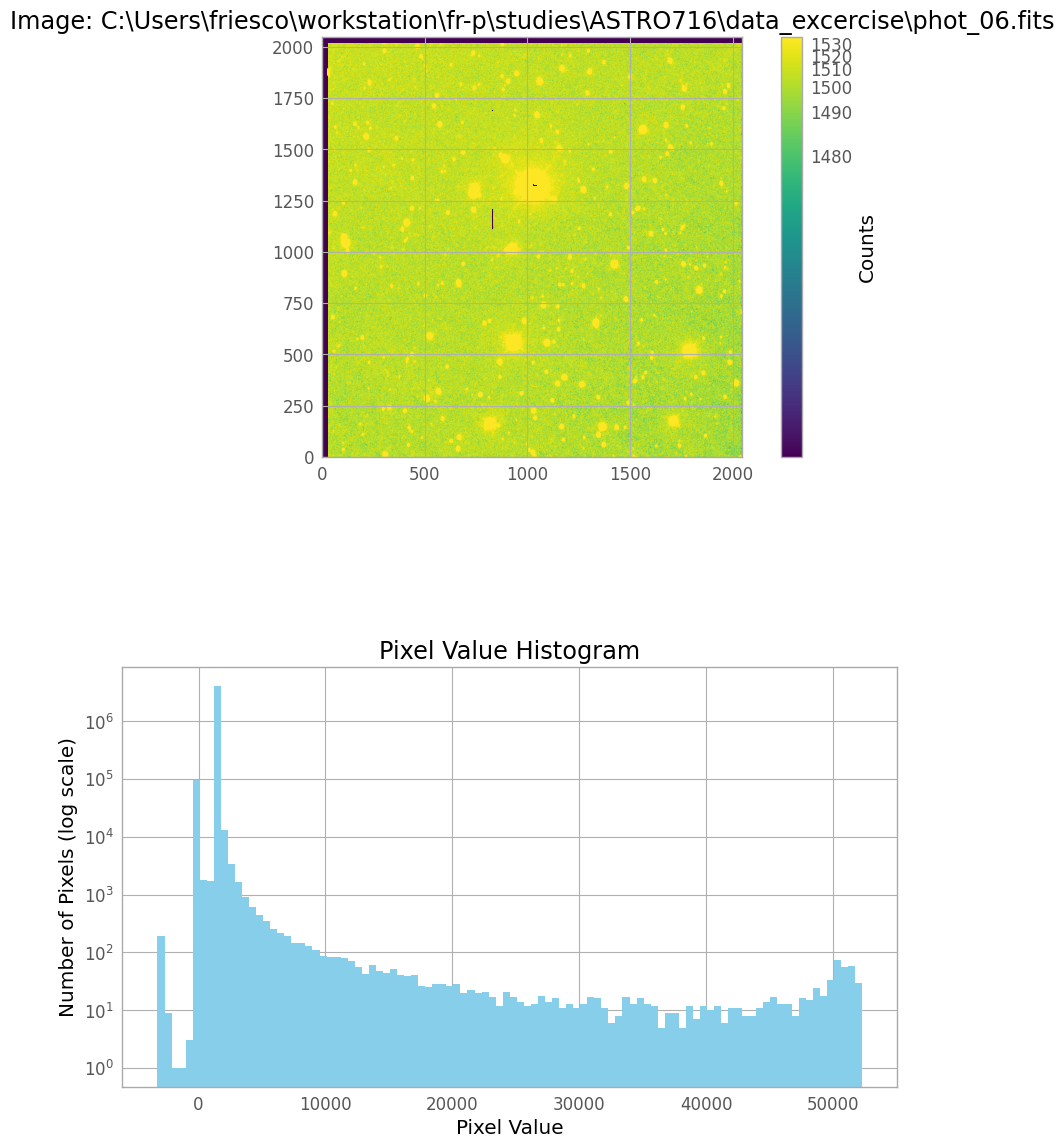

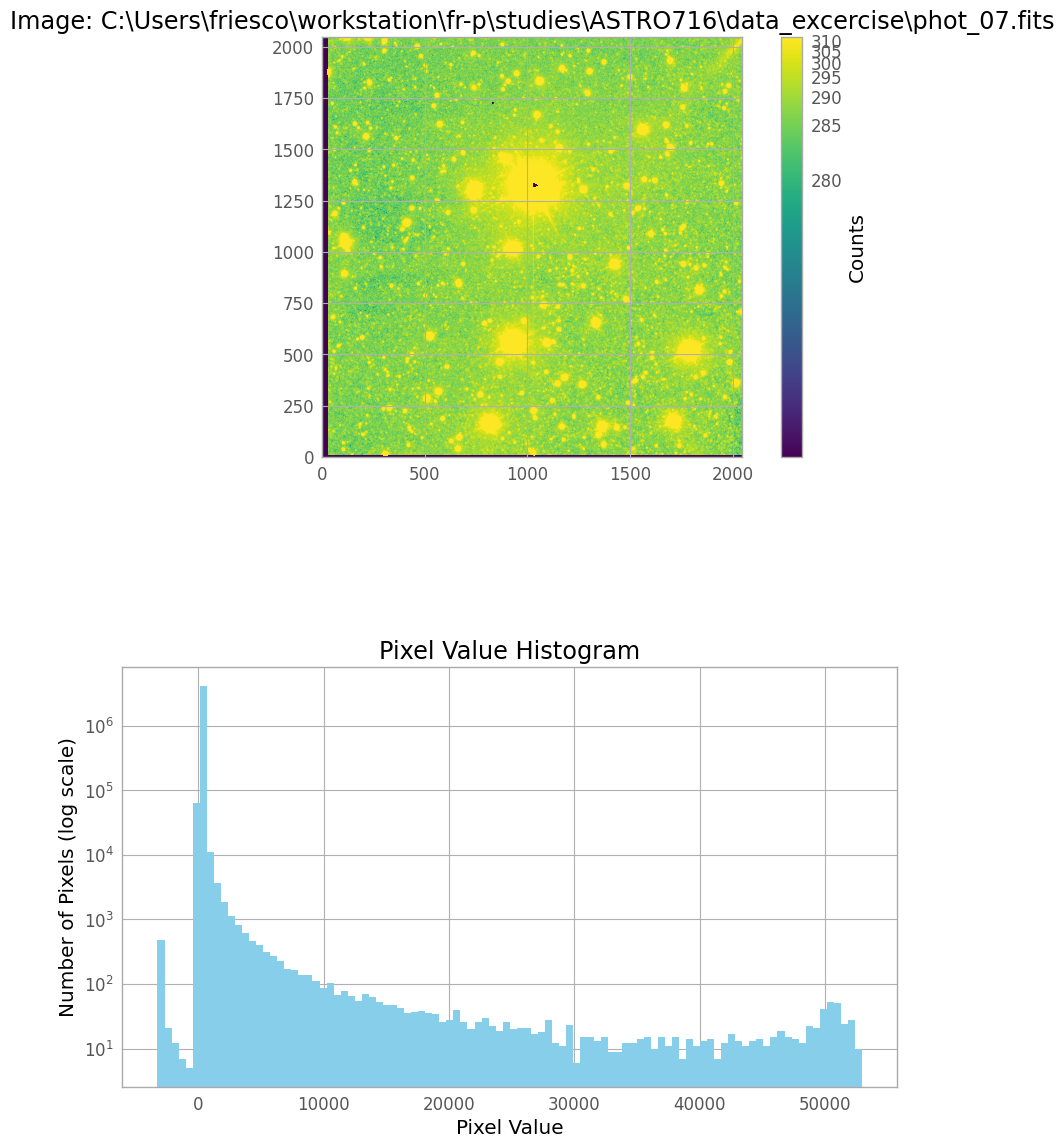

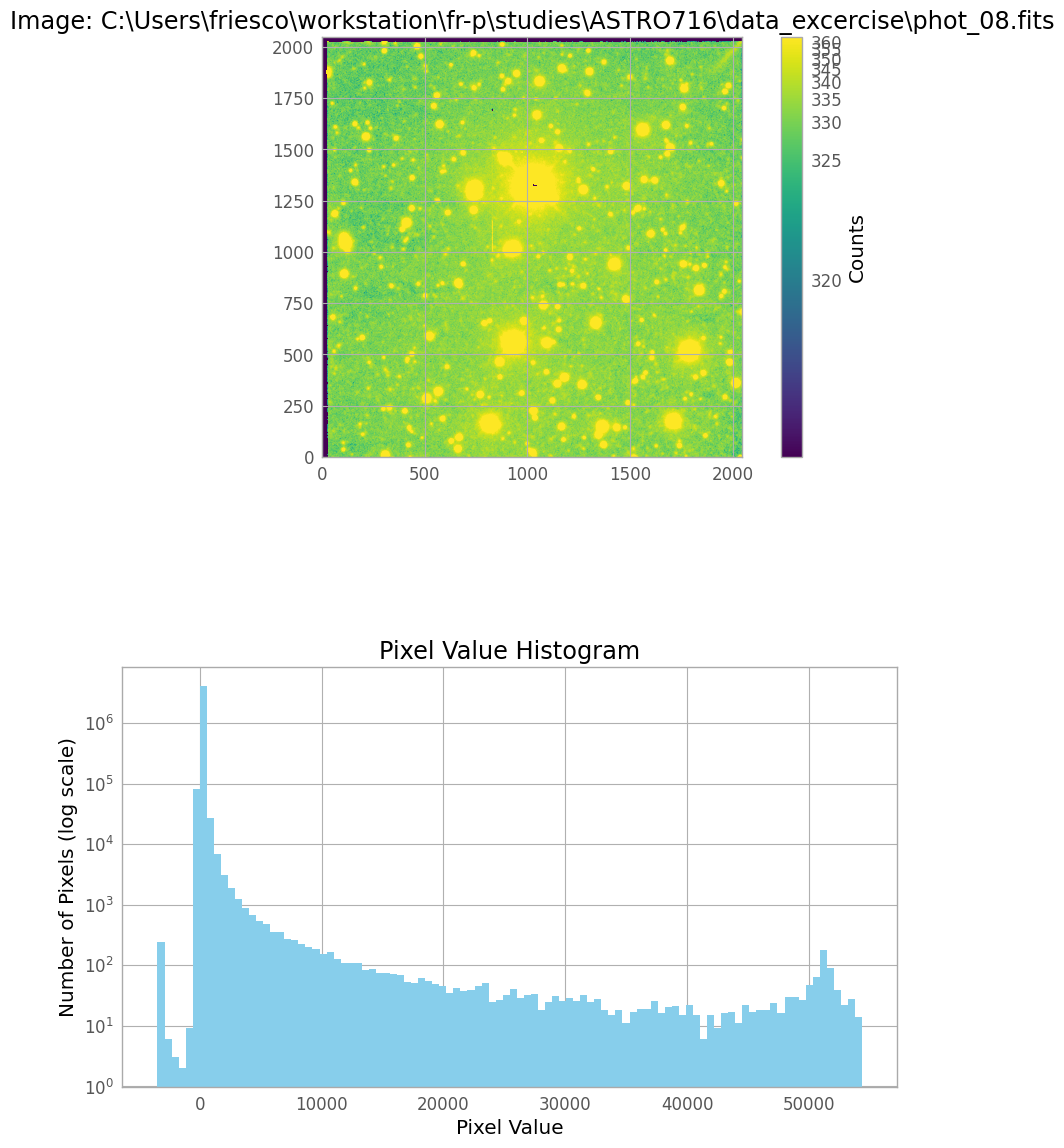

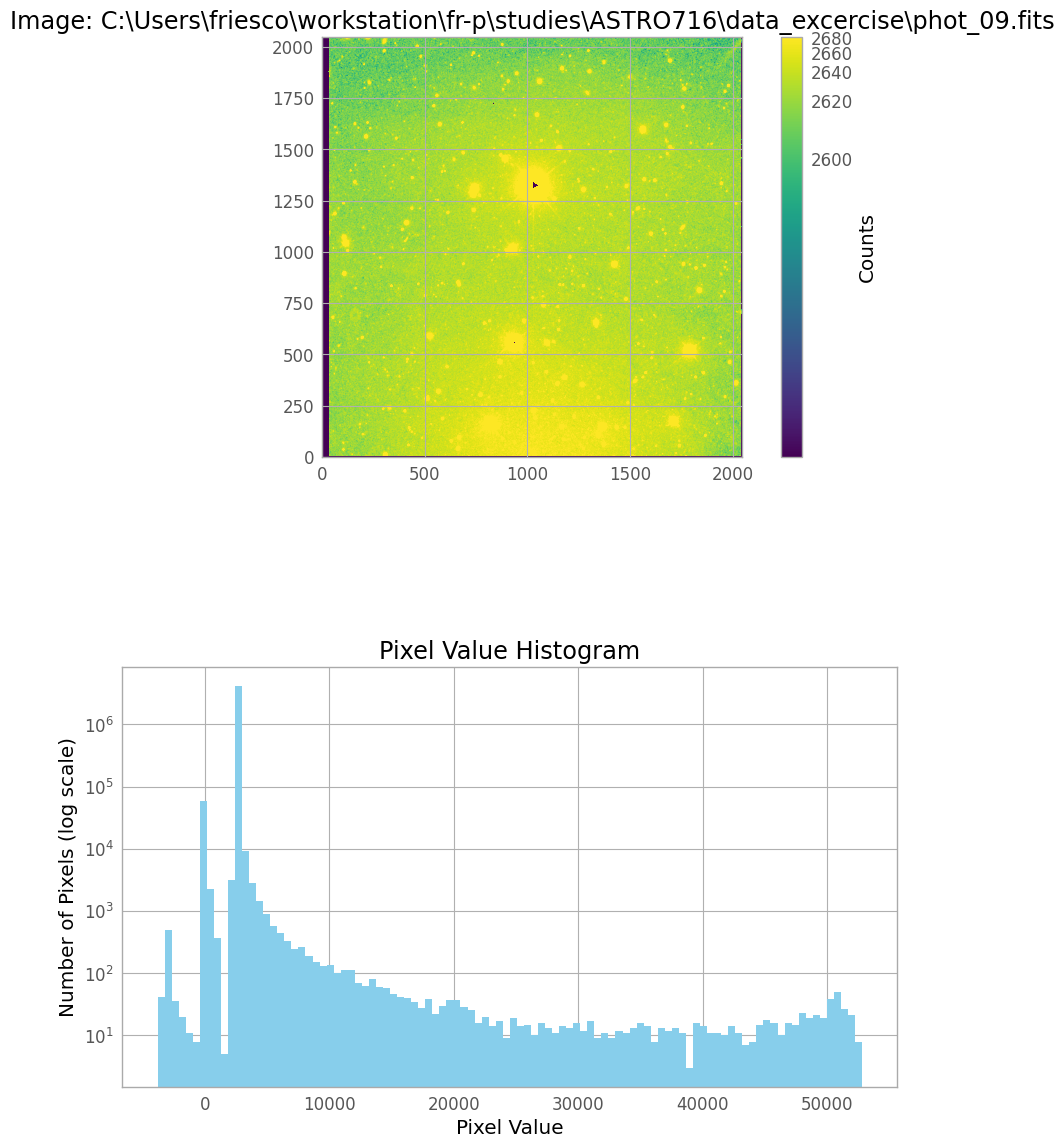

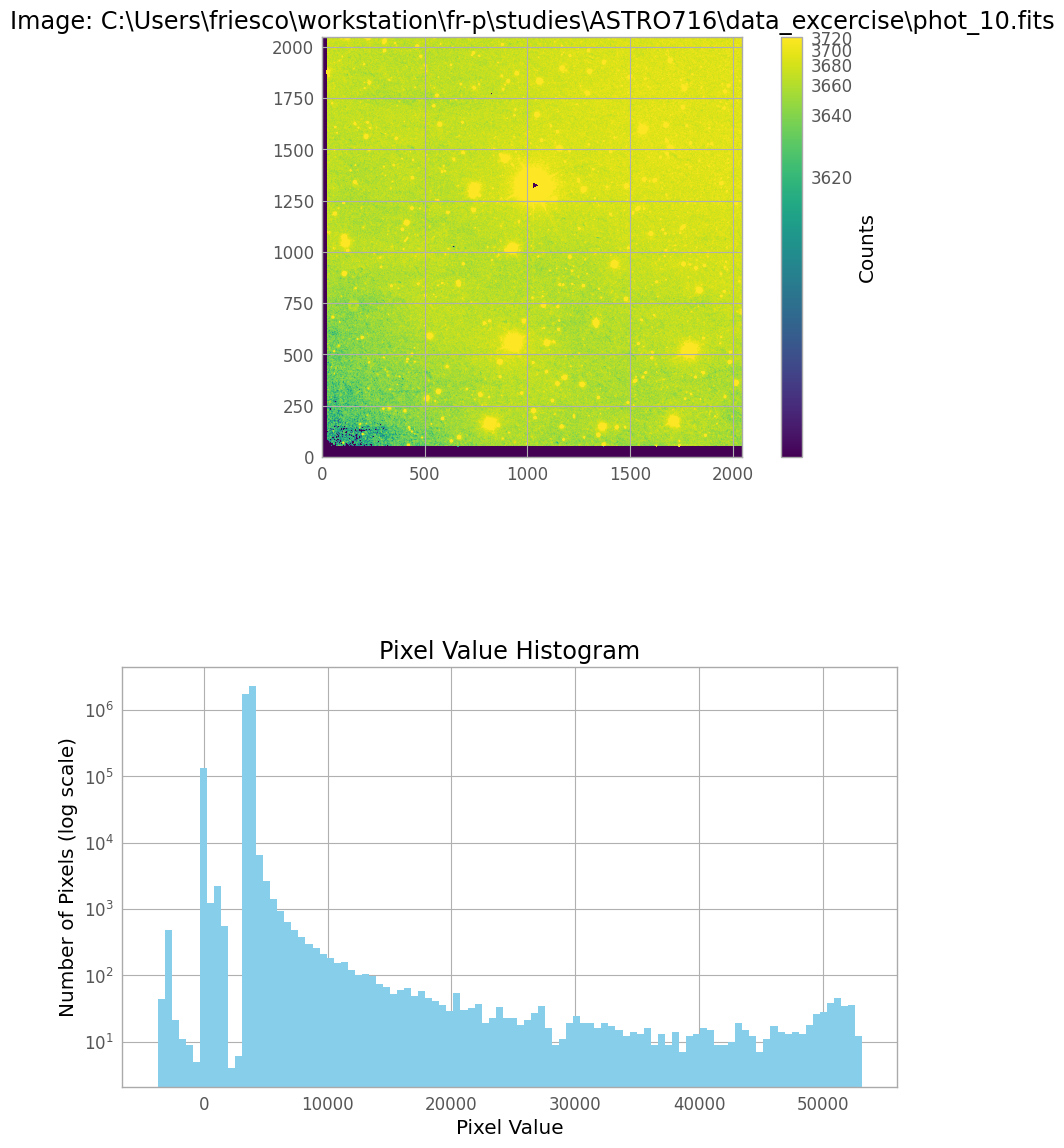

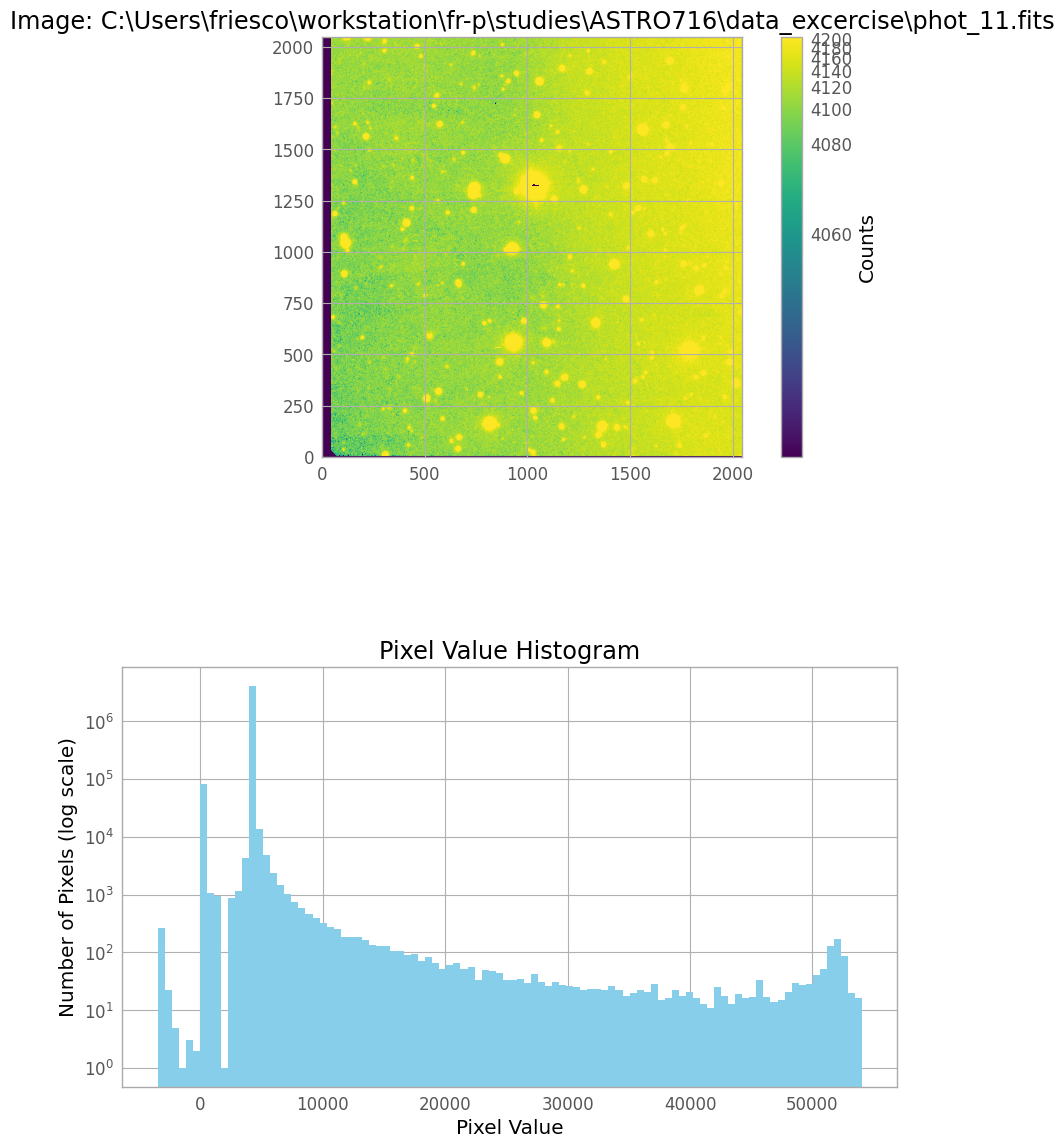

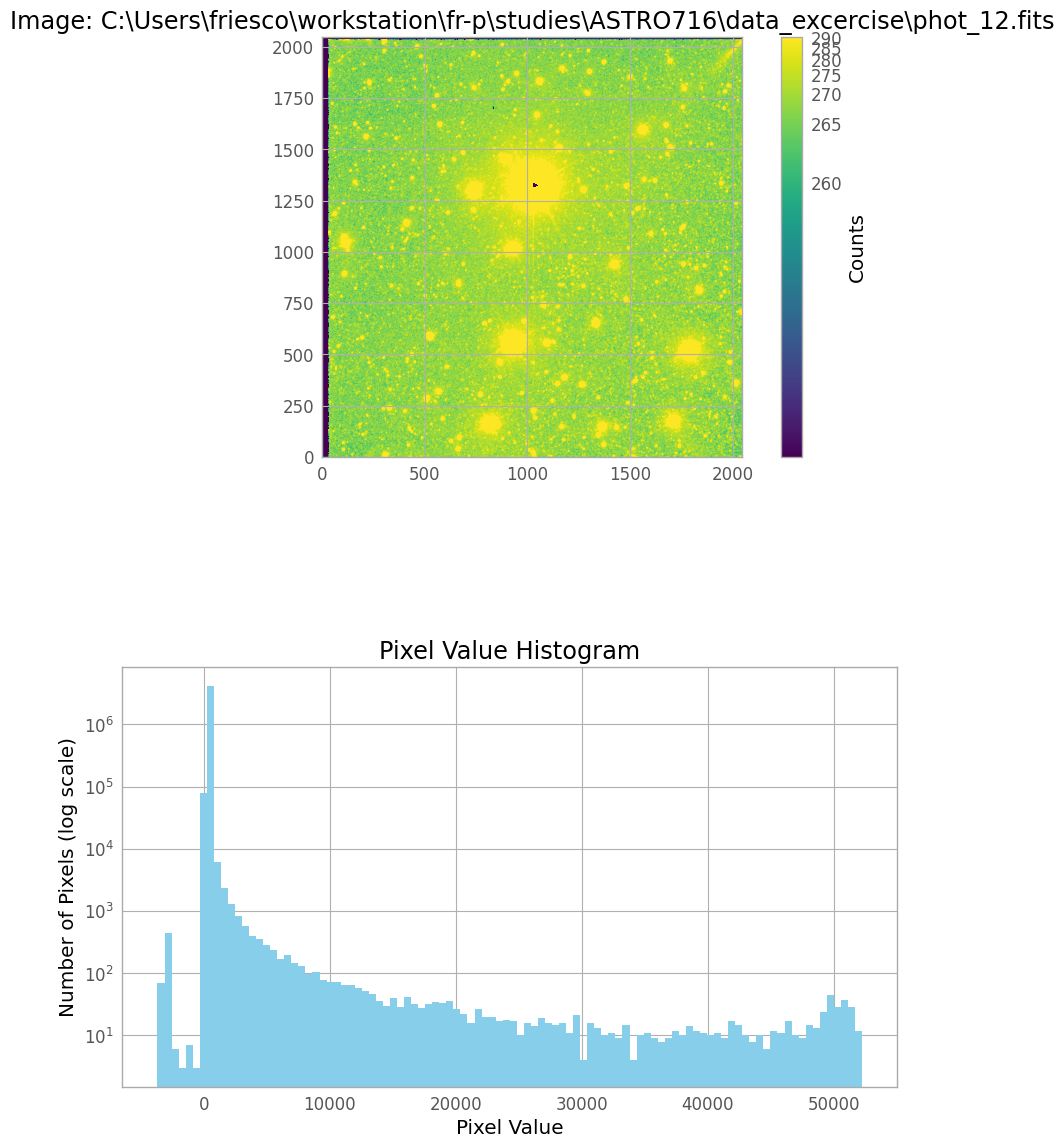

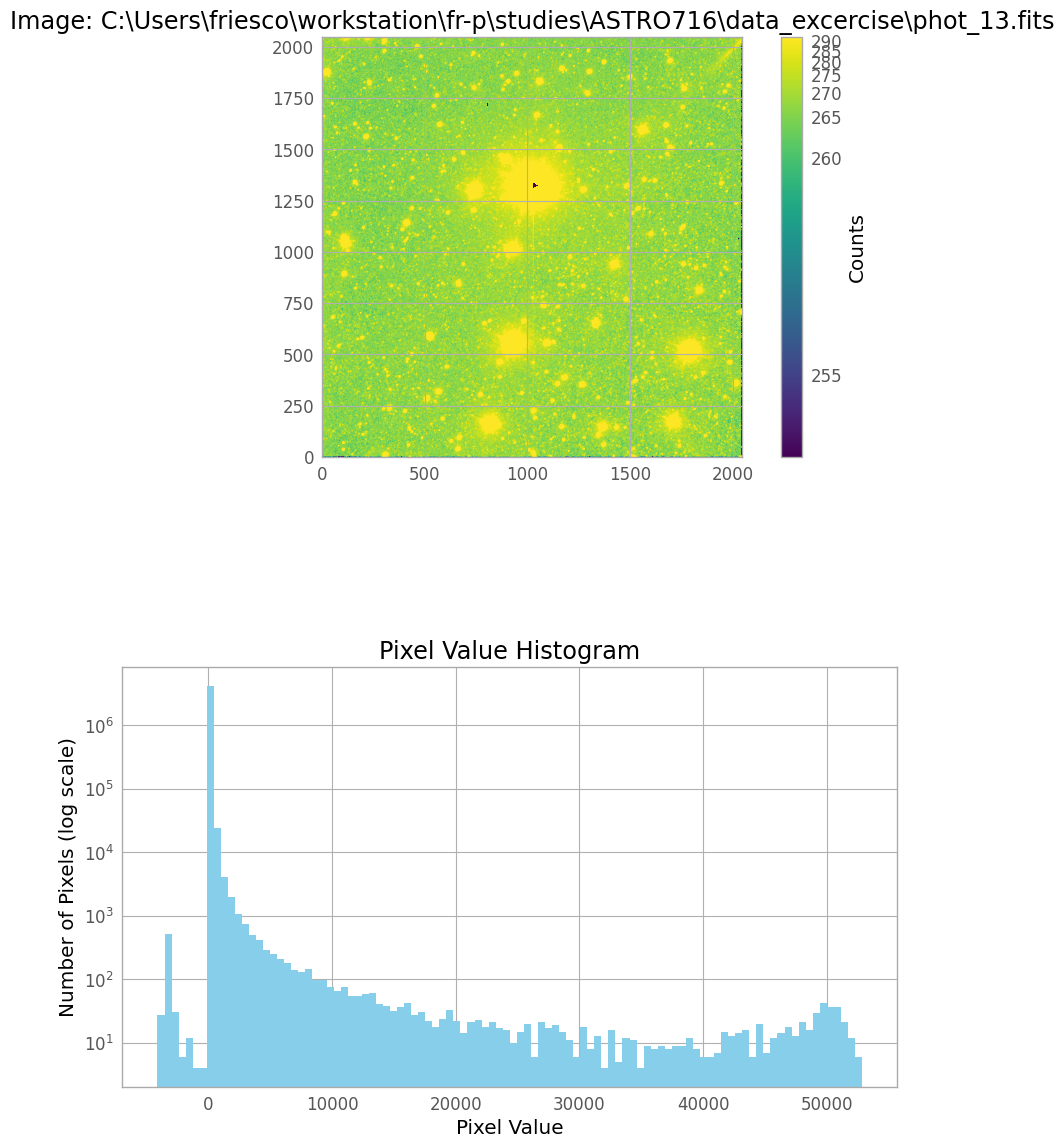

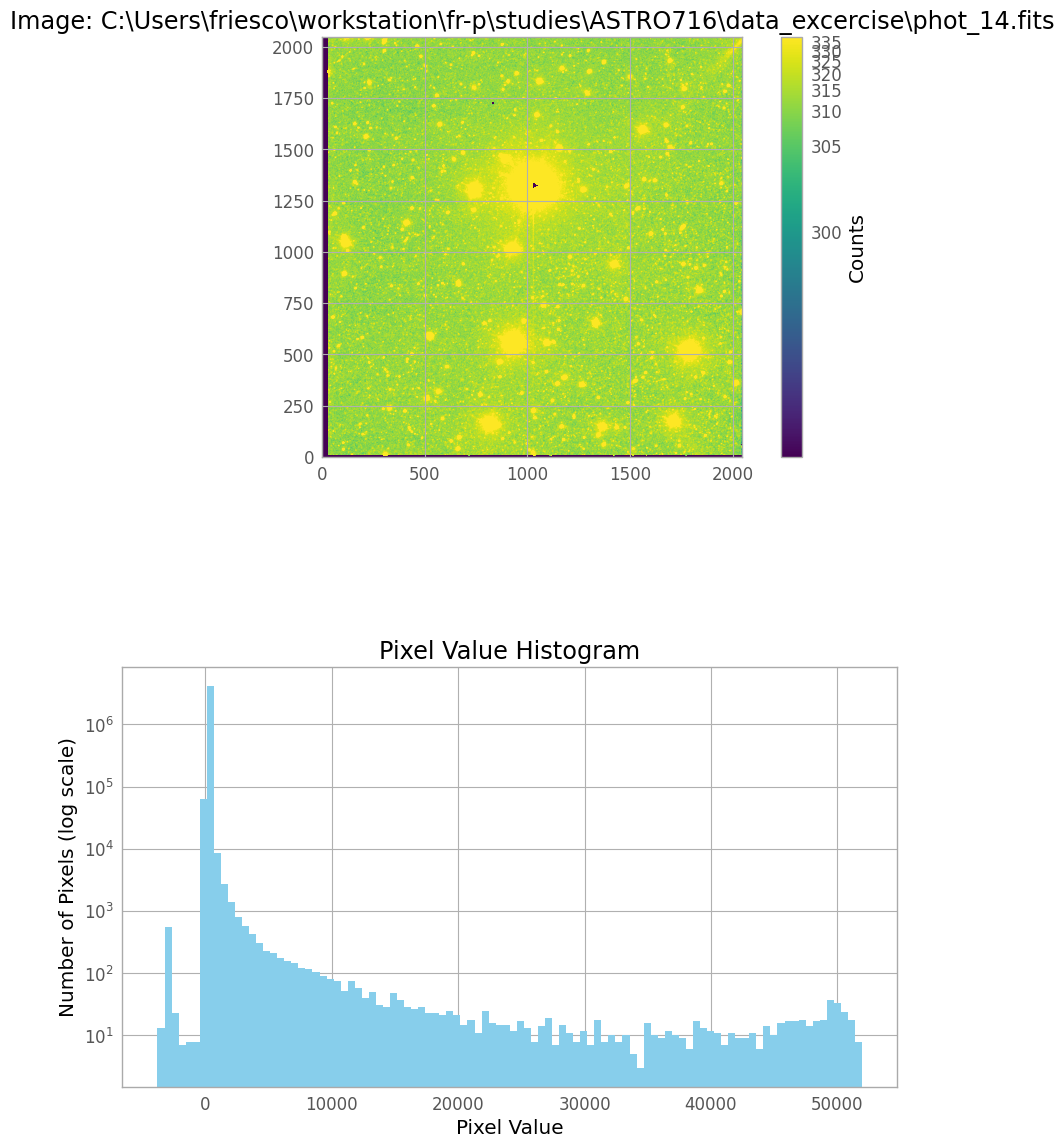

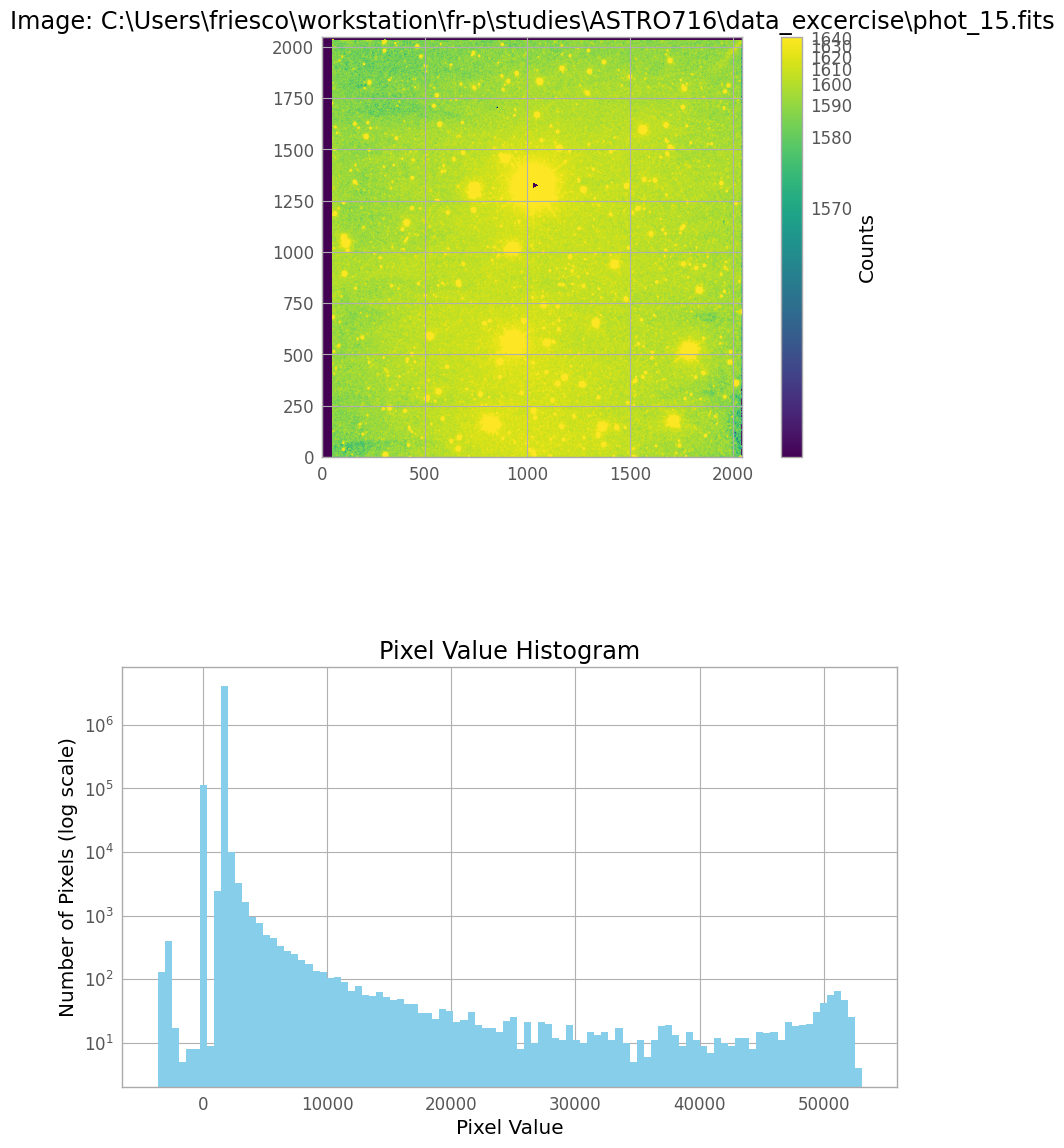

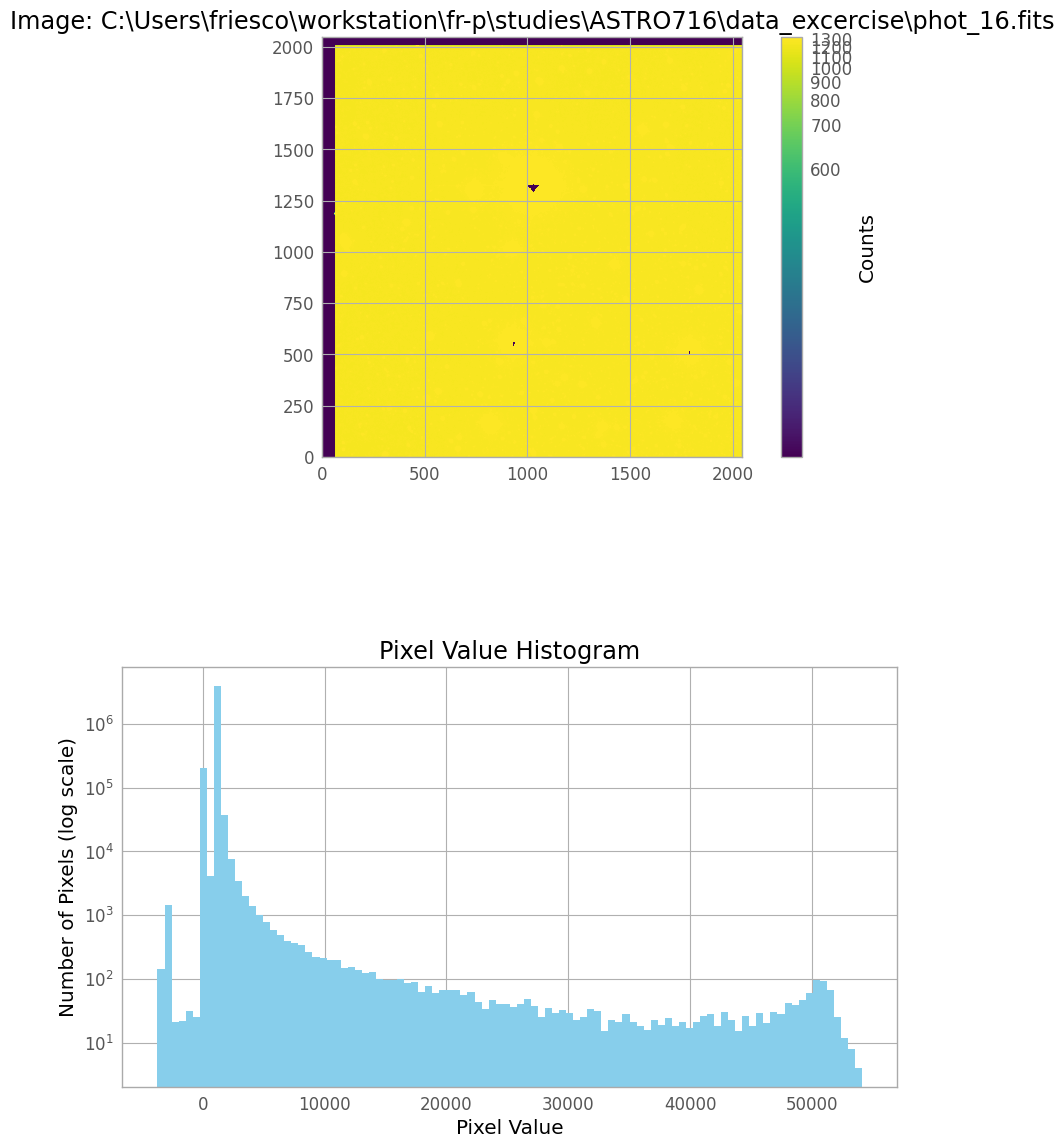

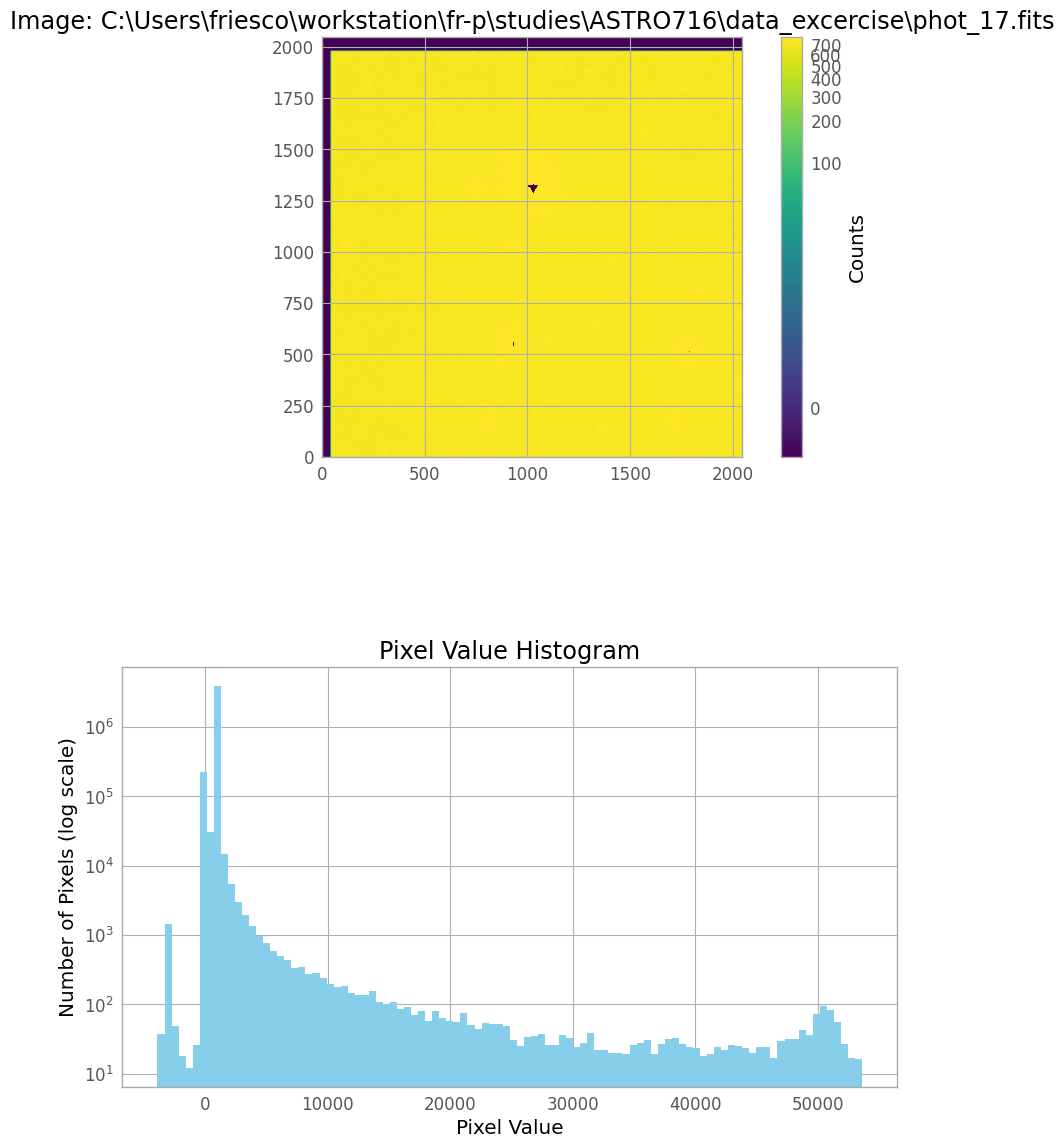

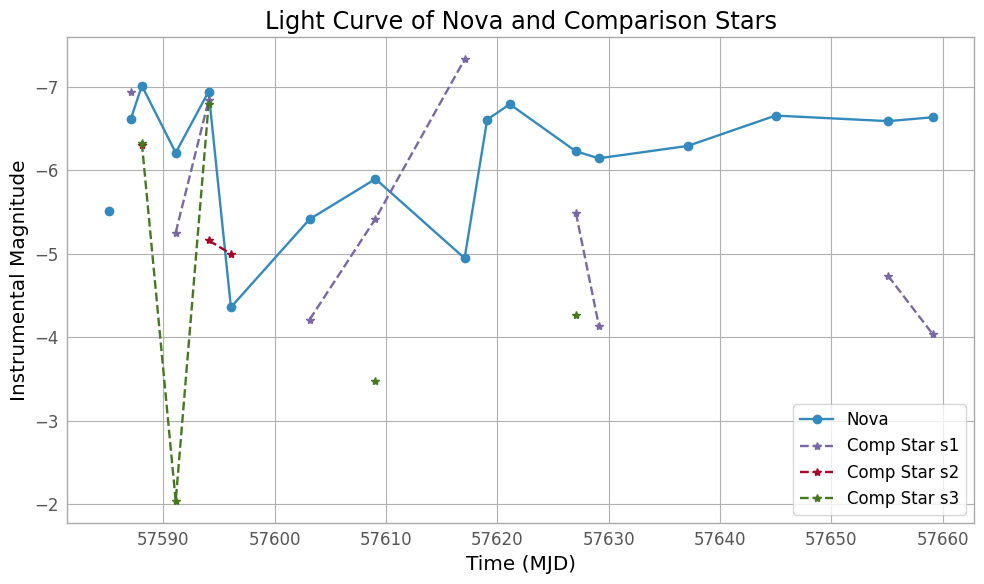

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import LogStretch
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
import os
from astropy.time import Time

plt.style.use(astropy_mpl_style)

wd = r"C:\Users\friesco\workstation\fr-p\studies\ASTRO716\data_excercise"

def ai(img, n_pos, a_rad, c_stars):
    try:
        h = fits.open(img)
        d = h[0].data
        hd = h[0].header
        if 'MJD' in hd:
            t = hd['MJD']
        elif 'DATE-OBS' in hd:
            t = hd['DATE-OBS']
        else:
            h.close()
            return None, None, None

        ap = CircularAperture(n_pos, r=a_rad)
        aa = CircularAnnulus(n_pos, r_in=10, r_out=15)
        pt = aperture_photometry(d, [ap, aa])
        bkg_mean = pt['aperture_sum_1'] / aa.area
        bkg_sum = bkg_mean * ap.area
        f_sum = pt['aperture_sum_0'] - bkg_sum

        if f_sum[0] > 0:
            inst_mag = -2.5 * np.log10(f_sum[0])
        else:
            inst_mag = np.nan

        inst_mags = {}
        for star, pos in c_stars.items():
            ap = CircularAperture(pos, r=a_rad)
            aa = CircularAnnulus(pos, r_in=10, r_out=15)
            pt = aperture_photometry(d, [ap, aa])
            bkg_mean = pt['aperture_sum_1'] / aa.area
            bkg_sum = bkg_mean * ap.area
            f_sum = pt['aperture_sum_0'] - bkg_sum

            if f_sum[0] > 0:
                inst_mags[star] = -2.5 * np.log10(f_sum[0])
            else:
                inst_mags[star] = np.nan

        h.close()
        return t, inst_mag, inst_mags

    except Exception as e:
        return None, None, None


n_pos = (286, 376)
a_rad = 5
c_stars = {'s1': (475, 459), 's2': (555, 439), 's3': (171, 543)}

ts, nms, cms = [], [], {s: [] for s in c_stars}

for i in range(18):
    img = os.path.join(wd, f"phot_{i:02d}.fits")
    t, nm, cm = ai(img, n_pos, a_rad, c_stars)
    if t is not None:
        ts.append(t)
        nms.append(nm)
        for s, m in cm.items():
            cms[s].append(m)

for i in range(18):
    img = os.path.join(wd, f"phot_{i:02d}.fits")
    try:
        h = fits.open(img)
        d = h[0].data
        h.close()
    except FileNotFoundError:
        continue

    fig, axes = plt.subplots(2, 1, figsize=(10, 14))
    norm = ImageNormalize(vmin=np.nanpercentile(d, 5), vmax=np.nanpercentile(d, 95), stretch=LogStretch())
    im = axes[0].imshow(d, origin='lower', cmap='viridis', norm=norm)
    fig.colorbar(im, ax=axes[0], label='Counts')
    axes[0].set_title(f'Image: {img}')
    axes[1].hist(d.flatten(), bins=100, color='skyblue', log=True)
    axes[1].set_title('Pixel Value Histogram')
    axes[1].set_xlabel('Pixel Value')
    axes[1].set_ylabel('Number of Pixels (log scale)')

    plt.subplots_adjust(bottom=0.15, top=0.9)
    plt.show()

plt.figure(figsize=(10, 6))
if all(isinstance(t, float) for t in ts):
    plt.plot(ts, nms, marker='o', linestyle='-', label='Nova')
    plt.xlabel("Time (MJD)")
elif all(isinstance(t, str) for t in ts):
    ts_dt = [Time(t).datetime for t in ts]
    plt.plot(ts_dt, nms, marker='o', linestyle='-', label='Nova')
    plt.xlabel("Time (DATE-OBS)")
    plt.xticks(rotation=45)
else:
    plt.plot(ts, nms, marker='o', linestyle='-', label='Nova')
    plt.xlabel("Time")
plt.ylabel("Instrumental Magnitude")
plt.title("Light Curve of Nova and Comparison Stars")
plt.gca().invert_yaxis()
for s, mags in cms.items():
    plt.plot(ts, mags, marker='*', linestyle='--', label=f'Comp Star {s}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
